In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


In [9]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [10]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

While trying to scale the MLP with big sequences we've seen that the number of parameters needed goes up really fast, modern LLMs like gpt4o can process upto 128000 tokens (a token is usually 2-5 chars), we are clearly doing something wrong. 

Our big problem is that the number of parameters depends on the input sequence length. So we can try to make an architecture that resembles the perceptron but holds a hidden state and uses linear layers to update it. 

Interestingly, by reusing many times the same layers, we can scale indefinetly the sequence length. 

What happens here is that the processing of the embeddings happens always from the same parameters, instead of needing different parameters for each time step 

Millions of parameters: 0.15
Epoch ___0 - Loss: 5.519
Epoch _300 - Loss: 2.754
Epoch _600 - Loss: 2.889
Epoch _900 - Loss: 2.392
Epoch 1200 - Loss: 2.295
Epoch 1500 - Loss: 2.213
Epoch 1800 - Loss: 2.178
Epoch 2100 - Loss: 2.366
Epoch 2400 - Loss: 2.237
Epoch 2700 - Loss: 2.068


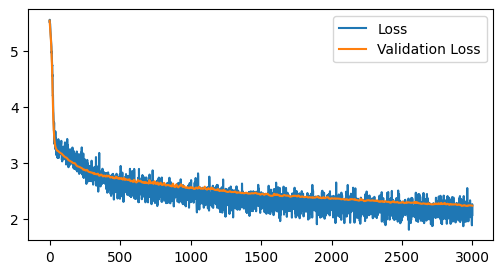

In [11]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fcxh = nn.Linear(emb_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, hidden_size) 
        self.fchh = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs) # removed flatten, shape is (batch_size, sequence_length, emb_size)
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) # (batch_size, hidden_size)
        
        for elm in range(emb.shape[1]):
            state = torch.tanh(self.fcxh(emb[:, elm]) + self.fchh(state))

        return self.fcxy(state)                


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RNN(emb_size=10, hidden_size=256, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()


In [12]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fcxh = nn.Linear(emb_size, hidden_size)
        self.fchh = nn.Linear(hidden_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, vocab_size) 
    
    def forward(self, inputs):
        emb = self.embeddings(inputs) # removed flatten, shape is (batch_size, sequence_length, emb_size)
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) # (batch_size, hidden_size)
        
        for elm in range(emb.shape[1]):
            state = torch.tanh(self.fcxh(emb[:, elm]) + self.fchh(state))

        return self.fcxy(state)                


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RNN(emb_size=10, hidden_size=128, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Millions of parameters: 0.03
Epoch ___0 - Loss: 4.184
Epoch _300 - Loss: 2.793


KeyboardInterrupt: 

Millions of parameters: 0.03
Epoch ___0 - Loss: 4.187
Epoch _300 - Loss: 3.080
Epoch _600 - Loss: 2.629
Epoch _900 - Loss: 2.722
Epoch 1200 - Loss: 2.348
Epoch 1500 - Loss: 2.442
Epoch 1800 - Loss: 2.473
Epoch 2100 - Loss: 2.493
Epoch 2400 - Loss: 2.188
Epoch 2700 - Loss: 2.567


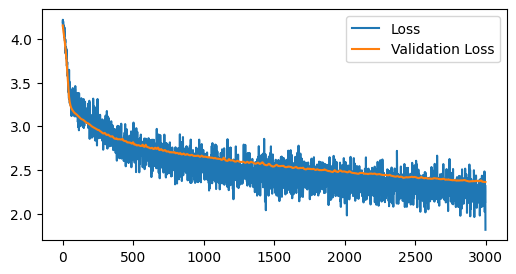

In [20]:
class LSTM(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.ui = nn.Linear(emb_size, hidden_size)
        self.uf = nn.Linear(emb_size, hidden_size)
        self.uo = nn.Linear(emb_size, hidden_size)
        self.ug = nn.Linear(emb_size, hidden_size)
        self.wi = nn.Linear(hidden_size, hidden_size)
        self.wf = nn.Linear(hidden_size, hidden_size)
        self.wo = nn.Linear(hidden_size, hidden_size)
        self.wg = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs)
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) # (batch_size, hidden_size)
        cell = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) # (batch_size, hidden_size)

        for elm in range(emb.shape[1]):
            i = torch.sigmoid(self.ui(emb[:, elm]) + self.wi(state))
            f = torch.sigmoid(self.uf(emb[:, elm]) + self.wf(state))
            o = torch.sigmoid(self.uo(emb[:, elm]) + self.wo(state))
            g = torch.tanh(self.ug(emb[:, elm]) + self.wg(state))
            cell = f * cell + i * g
            state = o * torch.tanh(cell)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RNN(emb_size=10, hidden_size=128, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()